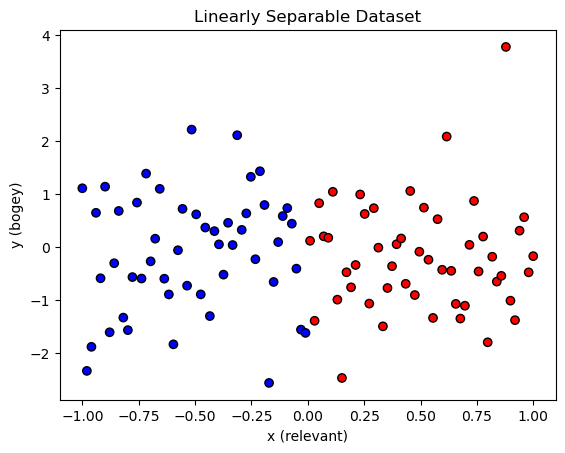

In [1]:
import torch
import matplotlib.pyplot as plt

# Generate a simple 2D linearly separable dataset
num_points = 100

# x values uniformly sampled from -1 to 1
x = torch.linspace(-1, 1, num_points)

# Random y values (bogey dimension)
y = torch.randn(num_points)  # This dimension is irrelevant

# Labels: 1 if x > 0, else 0
Y = (x > 0).int()

# Stack into a 2D dataset
X = torch.stack([x, y], dim=1)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="bwr", edgecolors="k")
plt.xlabel("x (relevant)")
plt.ylabel("y (bogey)")
plt.title("Linearly Separable Dataset")
plt.show()

# Create a dataloader for the dataset
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Split the dataset into a training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


In [2]:
import torch
from model.fully_connected_network import FullyConnectedNetwork
from core.energy import HopfieldEnergy
from core.updater import FixedPointUpdater
from training.runner import Runner
from training.cost import SquaredError
from training.equilibrium_propagation import EquilibriumProp
from util.config import Config

config = Config()
config.training["num_epochs"] = 5
network = FullyConnectedNetwork(config)
energy_fn = HopfieldEnergy(config)
cost_fn = SquaredError(config)
updater = FixedPointUpdater(network, energy_fn, cost_fn, config)

W, B = network.weights, torch.tensor(0.0) #network.bias # Need to verify if pointer or new creation. It should be pointer already but sanity check. 
optimizer = torch.optim.SGD([W, B], lr=0.5)
differentiator = EquilibriumProp(network, energy_fn, cost_fn, updater, config, optimizer)



config.path = "./results"

runner = Runner(config, network, train_loader, differentiator, updater, optimizer, inference_dataloader=test_loader)

In [3]:
from tqdm import tqdm
from collections import deque

correctness_log = deque(maxlen=5)

iter = 0
for x, target in tqdm(runner._dataloader, desc="Training Batches"):
    if iter > 10:
        break
    iter += 1

    runner._optimizer.zero_grad()
    S = runner._network.set_input(x)
    W, B = runner._network.weights, runner._network.biases            

    S = runner._updater.compute_equilibrium(S, W, B, target)
    weight_grads, bias_grads = runner._differentiator.compute_gradient(S, W, B, target)
    W.grad, B.grad = weight_grads, bias_grads
    runner._optimizer.step()

    W.data = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0],[5.0, -5.0, 0.0]])

    B.data = torch.tensor([0.0, 0.0, 20.0])

    S_pred = runner._updater.compute_equilibrium_pred(S, W, B)

    print(energy_fn.energy(W,S_pred, B))
    pred_value = round(S_pred.flatten().detach().numpy()[-1], 0)
    target_value = target.detach().numpy()[0]
    correct = int(pred_value == target_value)

    correctness_log.append(correct)
    rolling_accuracy = sum(correctness_log) / len(correctness_log)

    # print(f"\nSample {iter}, Target: {target_value}, Prediction: {pred_value}, Correct: {correct}")
    print()
    print("X:", [round(a, 3) for a in x.flatten().detach().numpy()])

    print("S:", [round(a, 3) for a in S.flatten().detach().numpy()])

    
print("W:", [[round(a, 3) for a in row] for row in W.detach().numpy()])
print("B:", [round(a, 3) for a in B.detach().numpy()])
    # print(f"Rolling Accuracy (Last {len(correctness_log)} samples): {round(rolling_accuracy * 100, 2)}%")

Training Batches:   0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (1) for operand 1 and no ellipsis was given